# Unit Root Econometrics
This notebook follows the first Monte Carlo exercise in Chapter 8 of Hayashi (2000). The aim of the exercise is to demonstrate that if a driftless random walk does not have a time trend, then the finite sample power of the Dickey-Fuller test of a driftless random walk against stationary alternatives is higher when the test is not based on a regression incorporating a time trend, although such a regression is theretically applicable.

## Theoretical Framework
Let $\{\varepsilon_t\}_{t \in \mathbb N}$ be an independent white noise process. Fix some initial value $y_0$ (which may be a random variable, but must have finite second moments), and define, for $t \in \mathbb N$:
$$y_t = \alpha + \delta t + \rho y_{t-1} + \varepsilon_t$$

We're interested in investigating whether $y_t$ is a random walk without drift. The null hypothesis is then:
$$
\begin{align*}
    \rho = 1 && \text{and} && \alpha = 0
\end{align*}
$$

There are two ways we could test this hypothesis using the Dickey-Fuller tests. First, if we know a priori that $\delta = 0$, we can regress $y_t$ on $y_{t-1}$ and a constant, and test whether the coefficient on $y_{t-1}$ is equal to 1. Second, if we are unsure whether $\delta = 0$, we can regress $y_t$ on $y_{t-1}$, a constant, and a time trend, and test whether the coefficient on $y_{t-1}$ is equal to 1. If we are correct in assuming $\delta = 0$, then both tests are valid, but the former test is more powerful than the latter, in the sense that the former test has a higher probability of rejecting the null hypothesis when it is false. However, if this assumption is incorrect, the first test is invalid (the relevant test statistic no longer converges in distribution to the same random variable), while the second test is still valid.

### Regression without a Time Trend
The regression model without a time trend can be written as:
$$y_t = \alpha + \rho y_{t-1} + \varepsilon_t$$

Let $\hat \rho^\mu$ denote the OLS estimator of $\rho$, and let $t^\mu$ denote the $t$ statistic for testing whether $\rho = 1$:
$$t^\mu = \frac{\hat \rho^\mu - 1}{s {\left[\sum_{t=1}^T (y_{t-1}^\mu)^2\right]}^{-\frac 12}}$$
where $y_t^\mu$ denotes the demeaned value of $y_t$ and $s^2$ is the OLS estimator of the variance of $\varepsilon_t$.

Under the null hypothesis that $y_t$ is a random walk without drift:
$$t^\mu \xrightarrow{d} \frac 12{\left([W^\mu(1)]^2 - [W^\mu(0)]^2 - 1\right)}{\left(\int^1_0[W^\mu(r)]^2 dr\right)}^{-\frac 12} \equiv \text{DF}_t^\mu$$
where $W^\mu$ is a demeaned standard Brownian motion. To conduct the one tailed test for a given nominal size, we compare the value of $t^\mu$ to the corresponding asymptotic critical value of $\text{DF}_t^\mu$, rejecting the null if $t^\mu < \text{DF}_t^\mu$.

### Regression with a Time Trend
The regression model with a time trend is:
$$y_t = \alpha + \delta t + \rho y_{t-1} + \varepsilon_t$$

Letting $\hat \rho^\tau$ denote the OLS estimator of $\rho$ in this regression, and letting $t^\tau$ denote the $t$ statistic for testing whether $\rho = 1$:
$$t^\tau = \frac{\hat \rho^\mu - 1}{s \sqrt{(X'X)^{-1}_{(3,3)}}}$$
where $X$ is the data matrix and $(X'X)^{-1}_{3, 3}$ is the third diagonal element of $(X'X)^{-1}$.

Under the null hypothesis that $y_t$ is a random walk without drift:
$$t^\mu \xrightarrow{d} \frac 12{\left([W^\tau(1)]^2 - [W^\tau(0)]^2 - 1\right)}{\left(\int^1_0[W^\tau(r)]^2 dr\right)}^{-\frac 12} \equiv \text{DF}_t^\tau$$
where $W^\tau$ is a detrended standard Brownian motion. The test is conducted in the same way as the test without a time trend using the asymptotic critical value of $\text{DF}_t^\tau$.

## Monte Carlo Framework
To investigate the power of the tests, we draw $T = 100$ i.i.d. observations on $\varepsilon$, set $y_0 = 0$, and define, for $t \in [100]$:
$$y_t = \alpha + \rho y_{t-1} + \varepsilon_t$$
with $(\alpha, \rho) = (0, 0.95)$.

Over a large number of replications and across various sample sizes ranging from 25-150, we compute the proportion of times that the null hypothesis is rejected at the 5% level for each of the two tests.

101


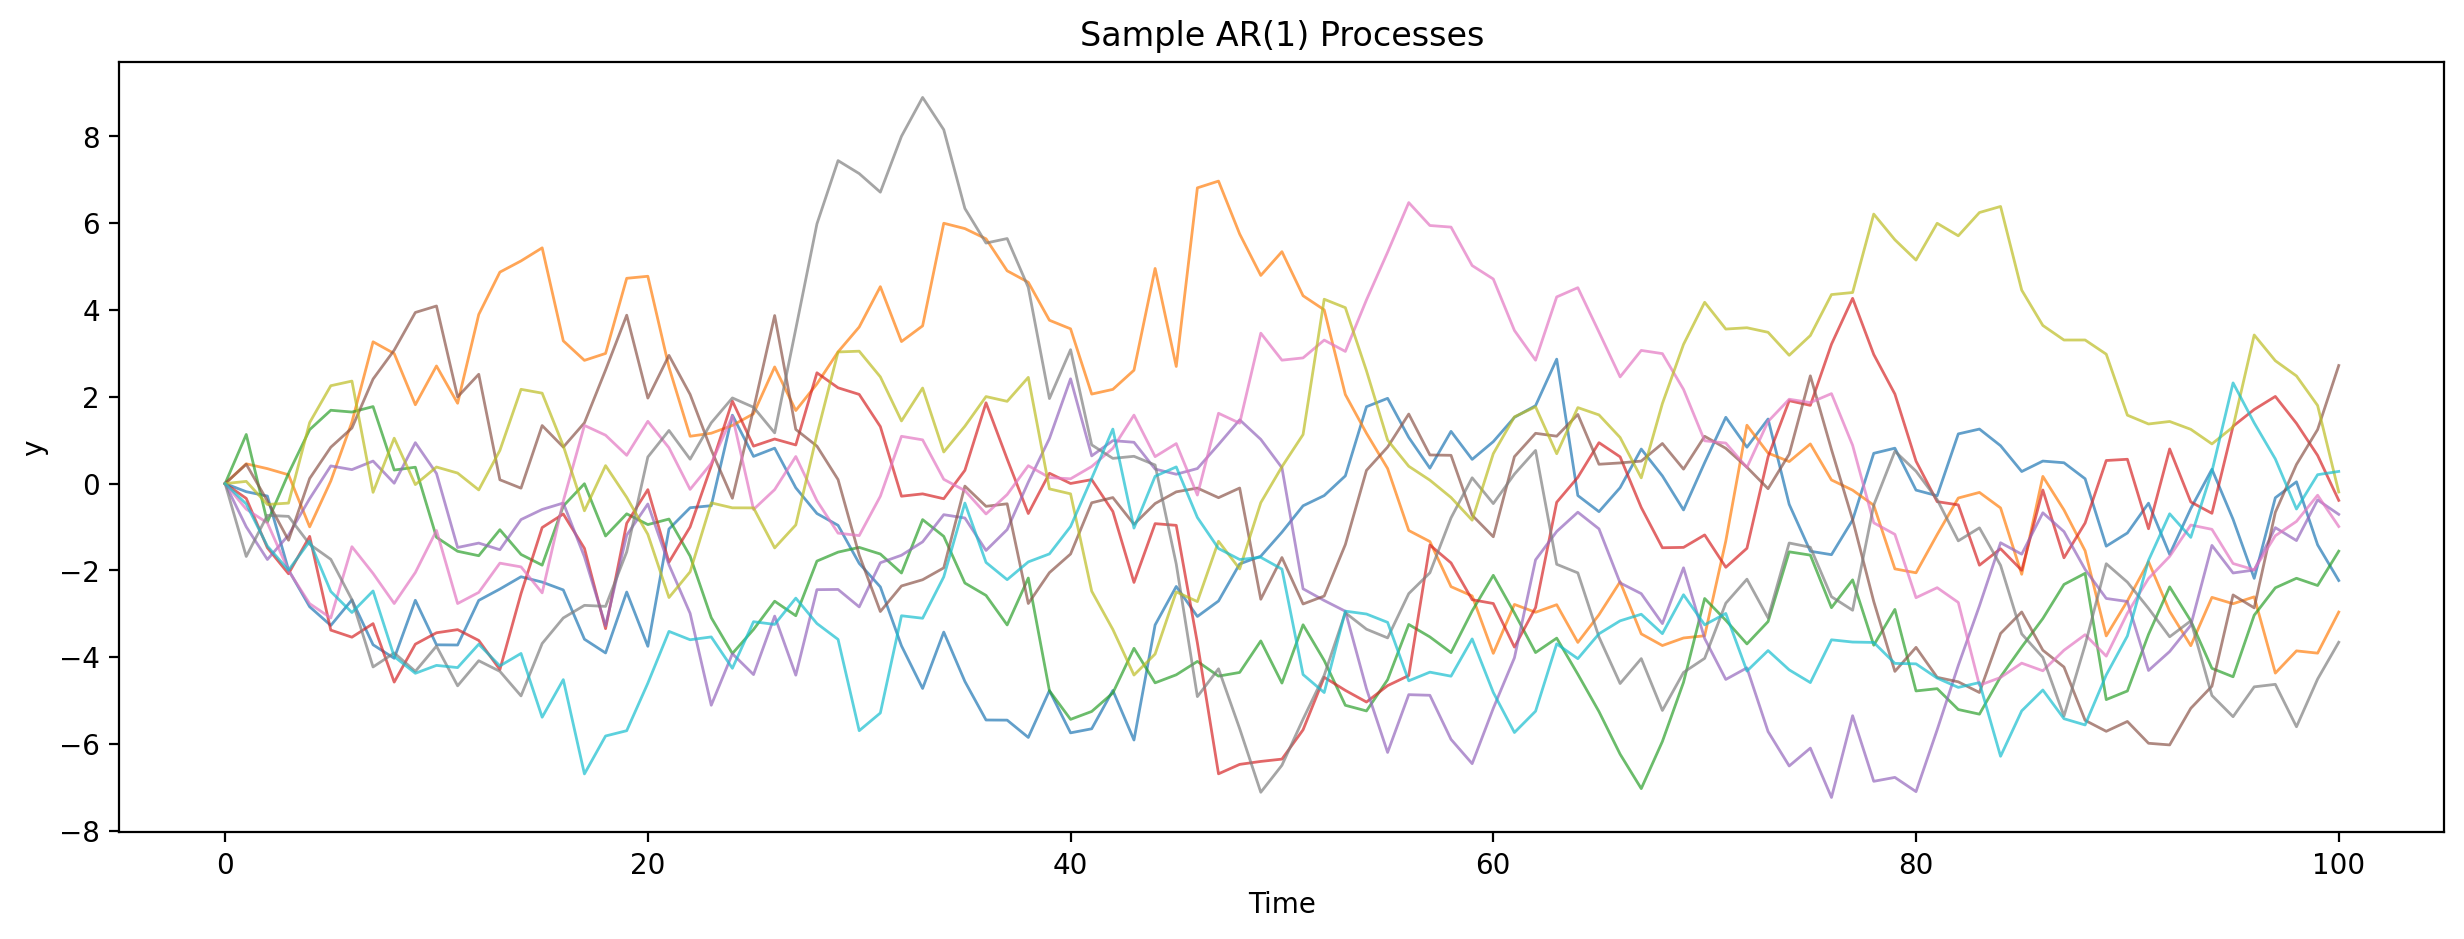

In [3]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
%config InlineBackend.figure_format = 'retina'

# Set the parameters
T = 100
rho = 0.95

# Define function to generate the data
def gen_y(T, rho):
    y = [0]
    
    eps = np.random.standard_normal(T)

    for t in range(T):
        y.append(rho * y[t] + eps[t])
    return y

# Plot sample outcomes of the DGP
y_samples = []
num_samples = 10
for i in range(num_samples):
    y_samples.append(gen_y(T, rho))

print(len(y_samples[0]))

# Plotting
for i in range(num_samples):
    plt.plot(y_samples[i], linewidth=1, alpha=0.7)

# Formatting
plt.rcParams['figure.figsize'] = [15, 5]
plt.title('Sample AR(1) Processes')
plt.xlabel('Time')
plt.ylabel('y')
plt.show()

In [4]:
# Define classes for the regression and t statistics
class RegressionNoTimeTrend:
    def __init__(self, y):
        self.y = y
        self.T = len(y)
        self.y_lag = np.insert(y[:-1], 0, 0)
        self.X = self.initialise_regressor_matrix()
        self.beta_hat = self.compute_beta_hat()
        self.rho_hat = self.beta_hat[1]
        self.y_hat = self.compute_predicted_y()
        self.resids = self.compute_resids()
        self.s = self.compute_s()
        self.t = self.compute_t()
    
    def initialise_regressor_matrix(self):
        X = np.column_stack((np.ones(self.T), self.y_lag))
        return X

    def compute_beta_hat(self):
        beta_hat = np.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.y
        return beta_hat

    def compute_predicted_y(self):
        y_hat = self.X @ self.beta_hat
        return y_hat

    def compute_resids(self):
        resids = self.y - self.y_hat
        return resids

    def compute_s(self):
        s = np.sqrt(self.resids.T @ self.resids / (self.T - 2))
        return s
    
    def compute_t(self):
        y_lag_mu = self.y_lag - self.y_lag.mean()
        t = (self.rho_hat - 1) / (self.s / np.sqrt(y_lag_mu.T @ y_lag_mu))
        return t

class RegressionTimeTrend:
    def __init__(self, y):
        self.y = y
        self.T = len(y)
        self.y_lag = np.insert(y[:-1], 0, 0)
        self.X = self.initialise_regressor_matrix()
        self.beta_hat = self.compute_beta_hat()
        self.rho_hat = self.beta_hat[2]
        self.y_hat = self.compute_predicted_y()
        self.resids = self.compute_resids()
        self.s = self.compute_s()
        self.t = self.compute_t()
    
    def initialise_regressor_matrix(self):
        X = np.column_stack((np.ones(self.T), np.arange(self.T), self.y_lag))
        return X

    def compute_beta_hat(self):
        beta_hat = np.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.y
        return beta_hat
    
    def compute_predicted_y(self):
        y_hat = self.X @ self.beta_hat
        return y_hat

    def compute_resids(self):
        resids = self.y - self.y_hat
        return resids

    def compute_s(self):
        s = np.sqrt(self.resids.T @ self.resids / (self.T - 3))
        return s
    
    def compute_t(self):
        XtX_inv = np.linalg.inv(self.X.T @ self.X)
        t = (self.rho_hat - 1) / (self.s * np.sqrt(XtX_inv[2, 2]))
        return t

In [5]:
n = np.arange(25, 151, 5) # Sample sizes to test
num_sample_sizes = len(n) # Number of sample sizes to test
num_replics = 1000000

# Estimate power of the tests for each sample size
t_mu_counter = np.zeros(num_sample_sizes)
t_tau_counter = np.zeros(num_sample_sizes)

for i in range(num_sample_sizes):
    # Repeat the hypothesis test num_replics times
    for j in range(num_replics):
        # Generate the data
        y = gen_y(n[i], rho)

        # Run the regression without a time trend
        reg_no_time_trend = RegressionNoTimeTrend(y)
        reg_time_trend = RegressionTimeTrend(y)

        # Check if the t statistic is less than -2.86 and increment the counter if it is
        if reg_no_time_trend.t < -2.86:
            t_mu_counter[i] += 1
        
        if reg_time_trend.t < -3.41:
            t_tau_counter[i] += 1

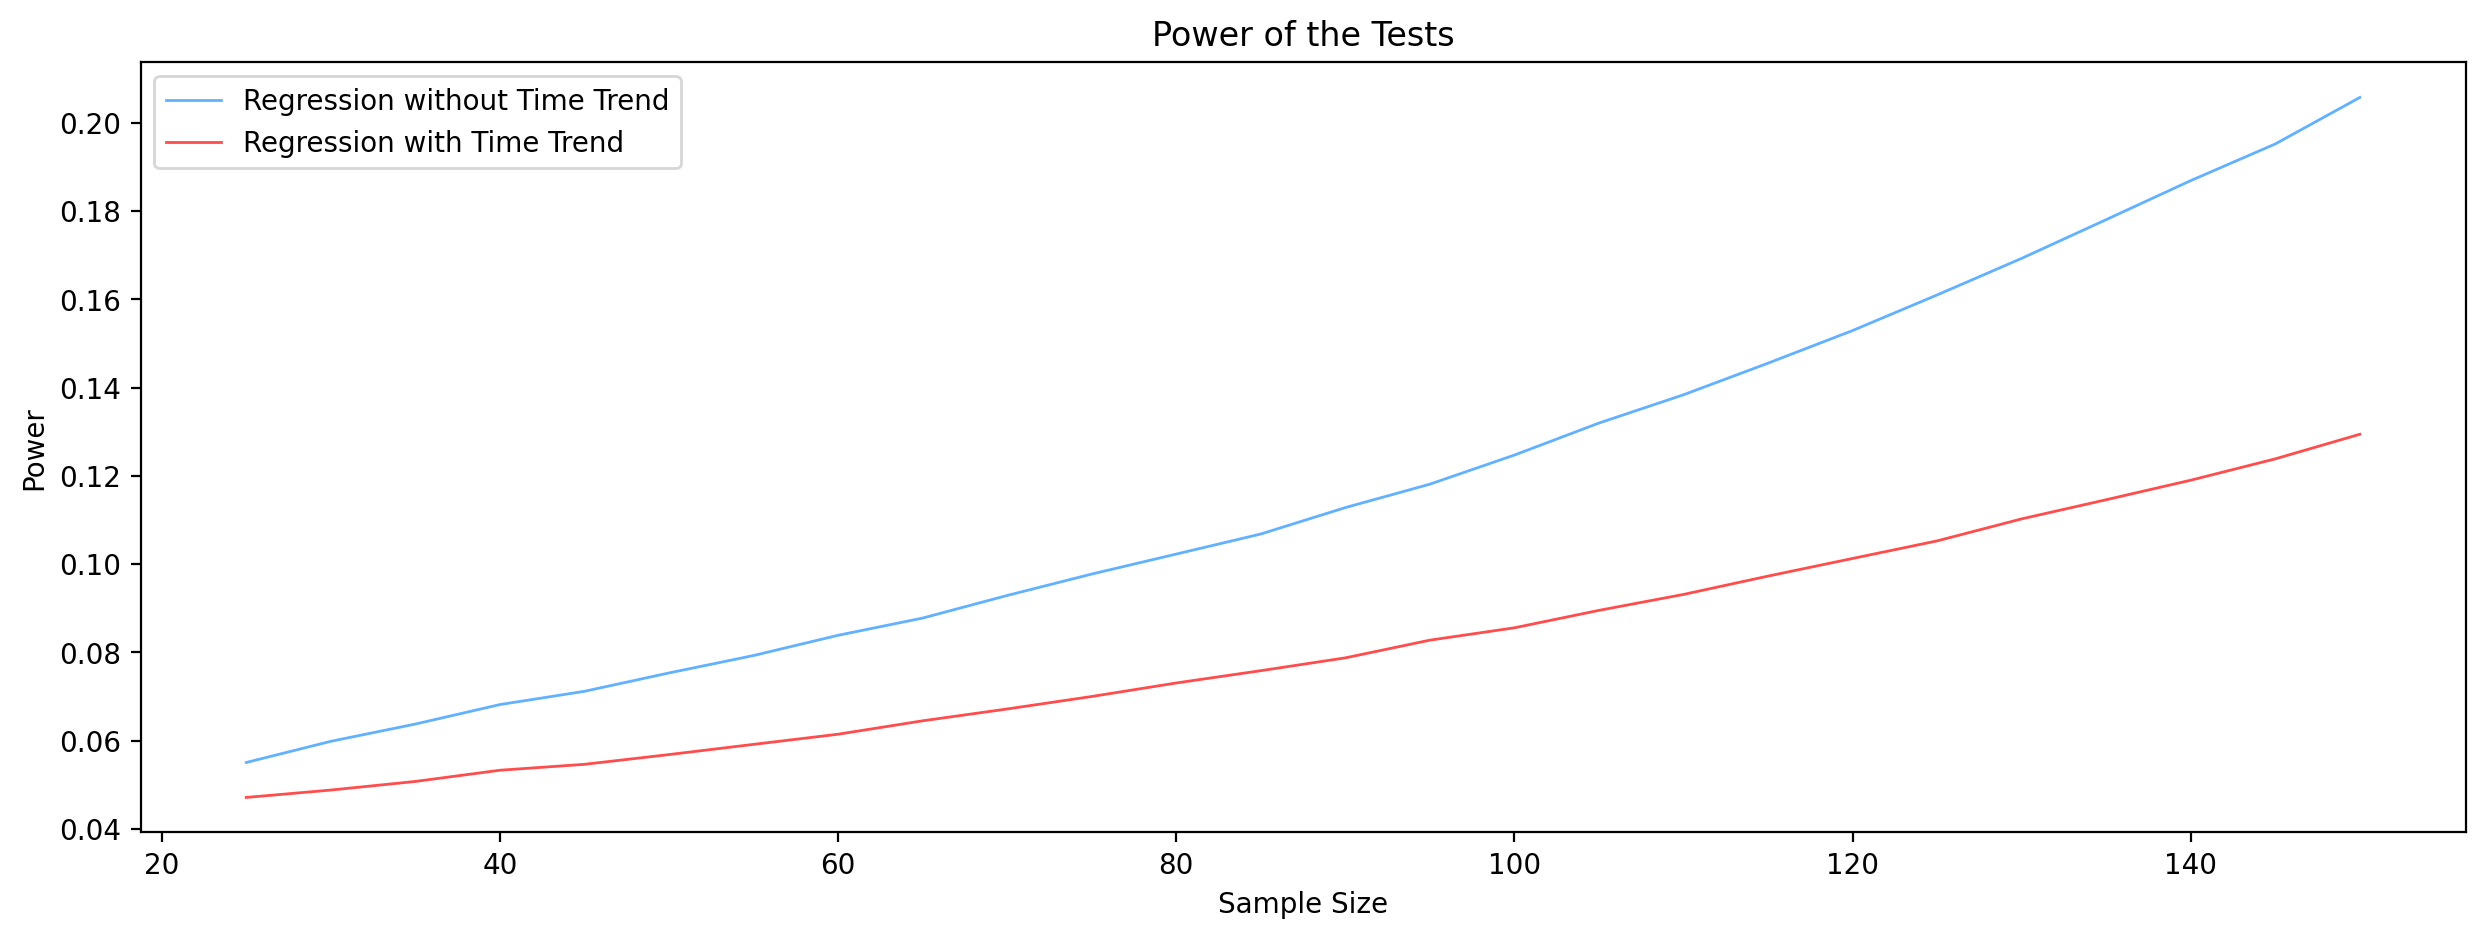

In [6]:
# Plot the power of the tests
plt.plot(n, t_mu_counter / num_replics, label="Regression without Time Trend", color="dodgerblue", linewidth=1, alpha=0.7)
plt.plot(n, t_tau_counter / num_replics, label="Regression with Time Trend", color="red", linewidth=1, alpha=0.7)
plt.title("Power of the Tests")
plt.xlabel("Sample Size")
plt.ylabel("Power")
plt.legend()
plt.show;